# Imports


In [0]:
import numpy as np
import pandas as pd
import random
import PIL
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow


import tensorflow as tf
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import regularizers
from keras import backend as K
K.set_image_dim_ordering('th')
K.set_image_data_format('channels_last')
from keras.applications import VGG16,VGG19
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Flatten,Dense
from keras.layers import Conv2D,Deconvolution2D,MaxPooling2D,UpSampling2D,Conv2DTranspose,GlobalAveragePooling2D

import os
import gc
import glob
import errno
import shutil
import zipfile

# **Colab File Handling**

## Google Drive

In [2]:
from google.colab import drive
while(True):
    try:
        drive.mount('/content/gdrive')
        break;
    except:
        continue

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Pydrive (To save files back to drive)

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))


In [0]:
downloaded = drive.CreateFile({'id': '1NSiN-nfPrKFvSvlxfKUmX4dy07cv9RWq'})
file = downloaded.GetContentString()
print('Downloaded content "{}"'.format(len(file)))

text_file = open("", "w")
text_file.write(file)    
text_file.close()

## Kaggle (!pwd is /content) (Run this twice)

In [2]:
!pip install kaggle
!mkdir .kaggle
import json
token = {"username":"deepcyan","key":"e32b4e0b8f1e56642a50b96adcd3c664"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats

mkdir: cannot create directory ‘.kaggle’: File exists
- path is now set to: /content
sampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
test1.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)


## Unzipping the dataset

In [0]:
PATH = "competitions/dogs-vs-cats/"

In [6]:
with open(PATH + "test1.zip", "rb") as zipsrc:
    zfile = zipfile.ZipFile(zipsrc)
    for member in zfile.infolist():
        target_path = member.filename
        if target_path.endswith('/'):  # folder entry, create
            try:
                os.makedirs(PATH + target_path)
            except (OSError, IOError) as err:
               # Windows may complain if the folders already exist
               if err.errno != errno.EEXIST:
                    raise
            continue
        with open(PATH + target_path, 'wb') as outfile, zfile.open(member) as infile:
            shutil.copyfileobj(infile, outfile)
            
        if(np.random.rand(1) > 0.99):
            flist = glob.glob(PATH + "test1/*.jpg")
            print(len(flist))
            
with open(PATH + "train.zip", "rb") as zipsrc:
    zfile = zipfile.ZipFile(zipsrc)
    for member in zfile.infolist():
        target_path = member.filename
        if target_path.endswith('/'):  # folder entry, create
            try:
                os.makedirs(PATH + target_path)
            except (OSError, IOError) as err:
               # Windows may complain if the folders already exist
               if err.errno != errno.EEXIST:
                    raise
            continue
        with open(PATH + target_path, 'wb') as outfile, zfile.open(member) as infile:
            shutil.copyfileobj(infile, outfile)
        '''
        if(np.random.rand(1) > 0.999):
            flist = glob.glob(PATH + "train/*.jpg")
            print(len(flist))
        '''

12500
12500
12500
12500
12500
12500
12500
12500
12500
12500
12500
12500
12500
12500
12500
12500
12500
12500
12500
12500
12500
12500
12500
12500
12500


KeyboardInterrupt: ignored

## Processing dataset

In [0]:
PATH = "competitions/dogs-vs-cats/"

In [0]:
PATH = PATH + "train/"
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
COLOUR_CHANNELS = 3
BATCH_SIZE = 64
IMAGE_SIZE = (IMAGE_WIDTH,IMAGE_HEIGHT)
IMAGE_DIMS = (IMAGE_WIDTH,IMAGE_HEIGHT,COLOUR_CHANNELS)

In [0]:
filenames = os.listdir(PATH)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append('1')
    else:
        categories.append('0')

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


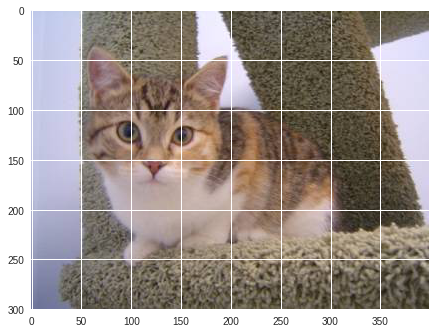

In [10]:
sample = 'cat.368.jpg'
image = load_img(PATH+sample)
plt.imshow(image)

In [0]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [12]:
train_df.head()

,category,filename
0,0,cat.5990.jpg
1,1,dog.2867.jpg
2,0,cat.12338.jpg
3,1,dog.6696.jpg
4,1,dog.11051.jpg


In [13]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    PATH, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    PATH, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

TRAIN_SIZE = train_df.shape[0]
VALIDATE_SIZE = validate_df.shape[0]

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


## Building Classifier model and training

In [0]:
VGG = VGG16(include_top = False, input_shape=(IMAGE_DIMS))

Classifier = models.Sequential()
 
Classifier.add(VGG)
Classifier.add(layers.Flatten())
Classifier.add(layers.Dense(128, activation='relu'))
Classifier.add(layers.Dense(1, activation='sigmoid'))
 
Classifier.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 15,763,521
Trainable params: 15,763,521
Non-trainable params: 0
_________________________________________________________________


In [0]:
Classifier.compile(loss='binary_crossentropy',optimizer=optimizers.adam(lr=1e-4),metrics=['acc'])

In [0]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10019354776684199471
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2462606917163657161
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3266924100189863508
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11276946637
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11625028094973571378
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [0]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [20]:
epochs=1
history = Classifier.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=VALIDATE_SIZE//BATCH_SIZE,
    steps_per_epoch=TRAIN_SIZE//BATCH_SIZE,
    callbacks=callbacks
)
Classifier.save_weights("model.h5")

Epoch 1/1
312/312 [==============================] - 243s 778ms/step - loss: 0.0491 - acc: 0.9813 - val_loss: 0.0438 - val_acc: 0.9838


In [0]:
Classifier.save("aft10epoch.g5")

## Loading trained classifer model and freezing


In [15]:
cd gdrive/My\ Drive

[Errno 2] No such file or directory: 'gdrive/My Drive'
/content/gdrive/My Drive


In [0]:
tf.reset_default_graph()

In [17]:
from keras.models import load_model
Classifier = load_model("a10.g5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [20]:
cd ../..

/


In [0]:
for layer in Classifier.layers:
    layer.trainable = False
    
Classifier.compile(loss='binary_crossentropy',optimizer=optimizers.adam(lr=1e-4),metrics=['acc'])

In [22]:
Classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 15,763,521
Trainable params: 0
Non-trainable params: 15,763,521
_________________________________________________________________


## Training metrics for Classifier model


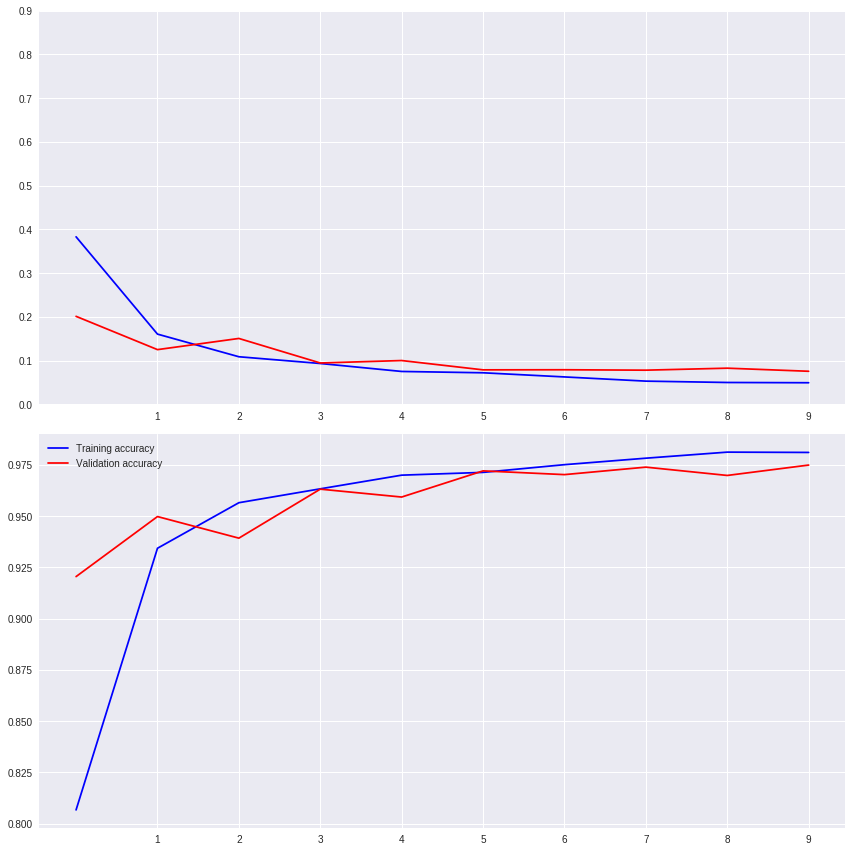

In [0]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Building and training Adversarial Model

### Other possible stuctures

In [0]:
'''
adversarialModel = models.Sequential()
adversarialModel.add(Conv2D(filters = 64, kernel_size= (3,3), input_shape=(IMAGE_DIMS), activation = 'relu'))
adversarialModel.add(MaxPooling2D((2,2), strides = 2))
adversarialModel.add(Conv2D(filters = 128, kernel_size= (3,3), activation = 'relu'))
adversarialModel.add(MaxPooling2D((2,2), strides = 2))
adversarialModel.add(Conv2D(filters = 256, kernel_size= (3,3), activation = 'relu'))
adversarialModel.add(MaxPooling2D((2,2), strides = 2))

adversarialModel.add(Conv2DTranspose(filters = 128, kernel_size = 2, activation = 'relu'))
adversarialModel.add(UpSampling2D(size = (2,2), data_format = 'channels_last', interpolation = 'bilinear'))
adversarialModel.add(Conv2DTranspose(filters = 64, kernel_size = 2, activation = 'relu'))
adversarialModel.add(UpSampling2D(size = (2,2), data_format = 'channels_last', interpolation = 'bilinear'))
adversarialModel.add(Conv2DTranspose(filters = 64, kernel_size = 2, activation = 'relu'))
adversarialModel.add(UpSampling2D(size = (2,2), data_format = 'channels_last', interpolation = 'bilinear'))
adversarialModel.add(Conv2DTranspose(filters = 3, kernel_size = 3, activation = 'relu', activity_regularizer=regularizers.l1(10e-5)))
'''

In [0]:
'''
adversarialModel = models.Sequential()
adversarialModel.add(Conv2D(filters = 64, kernel_size= (3,3), input_shape=(IMAGE_DIMS), activation = 'relu', padding = 'same'))
adversarialModel.add(MaxPooling2D((2,2), strides = 2))
adversarialModel.add(Conv2D(filters = 128, kernel_size= (3,3), activation = 'relu', padding = 'same'))
adversarialModel.add(MaxPooling2D((2,2), strides = 2))
adversarialModel.add(Conv2D(filters = 256, kernel_size= (3,3), activation = 'relu', padding = 'same'))
adversarialModel.add(UpSampling2D(size = (2,2), data_format = 'channels_last', interpolation = 'bilinear'))
adversarialModel.add(Conv2D(filters = 128, kernel_size= (3,3), activation = 'relu', padding = 'same'))
adversarialModel.add(UpSampling2D(size = (2,2), data_format = 'channels_last', interpolation = 'bilinear'))
adversarialModel.add(Conv2D(filters = 32, kernel_size= (3,3), activation = 'relu', padding = 'same'))
adversarialModel.add(Conv2D(filters = 3, kernel_size= (3,3), activation = 'tanh', padding = 'same',activity_regularizer=regularizers.l1(10e-5)))
'''

In [0]:
adversarialModel = models.Sequential()
adversarialModel.add(Conv2D(filters = 64, kernel_size= (3,3), input_shape=(IMAGE_DIMS), activation = 'relu', padding = 'same'))
adversarialModel.add(MaxPooling2D((2,2), strides = 2))
adversarialModel.add(Conv2D(filters = 128, kernel_size= (3,3), activation = 'relu', padding = 'same'))
adversarialModel.add(MaxPooling2D((2,2), strides = 2))
adversarialModel.add(Conv2D(filters = 256, kernel_size= (3,3), activation = 'relu', padding = 'same'))
adversarialModel.add(UpSampling2D(size = (2,2), data_format = 'channels_last', interpolation = 'bilinear'))
adversarialModel.add(Conv2D(filters = 128, kernel_size= (3,3), activation = 'relu', padding = 'same'))
adversarialModel.add(UpSampling2D(size = (2,2), data_format = 'channels_last', interpolation = 'bilinear'))
adversarialModel.add(Conv2D(filters = 32, kernel_size= (3,3), activation = 'relu', padding = 'same'))
adversarialModel.add(Conv2D(filters = 3, kernel_size= (3,3), activation = 'tanh', padding = 'same',activity_regularizer=regularizers.l1(10e-9)))

In [24]:
adversarialModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 128)       295040    
__________

In [0]:
'''missloss= []
x = tf.placeholder(tf.float32, shape=(None,128,128,3))
y = tf.placeholder(tf.float32, shape=(None,1))
noise = adversarialModel(x)
prediction = Classifier(x+noise)
print(type(noise))
missterm = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y, 1-prediction))
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss = missterm)
'''

<class 'tensorflow.python.framework.ops.Tensor'>


In [25]:
missloss= []
x = tf.placeholder(tf.float32, shape=(None,128,128,3))
y = tf.placeholder(tf.float32, shape=(None,1))
noise = adversarialModel(x)
prediction = Classifier(x+noise)
missterm = tf.keras.losses.BinaryCrossentropy()(y_true = y, y_pred= 1-prediction)
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss = missterm)

Instructions for updating:
Use tf.cast instead.


In [0]:
iter = 0
with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    
    while(True):
        
        data = validation_generator.next()
        
        
        iter = iter + 1
        
        _,runloss= sess.run([train_step, missterm], feed_dict = {x:data[0], y:np.expand_dims(data[1],axis = 1)})
        missloss.append(runloss)
        if(iter == 10):
            sess.close()
            break

In [0]:
missloss

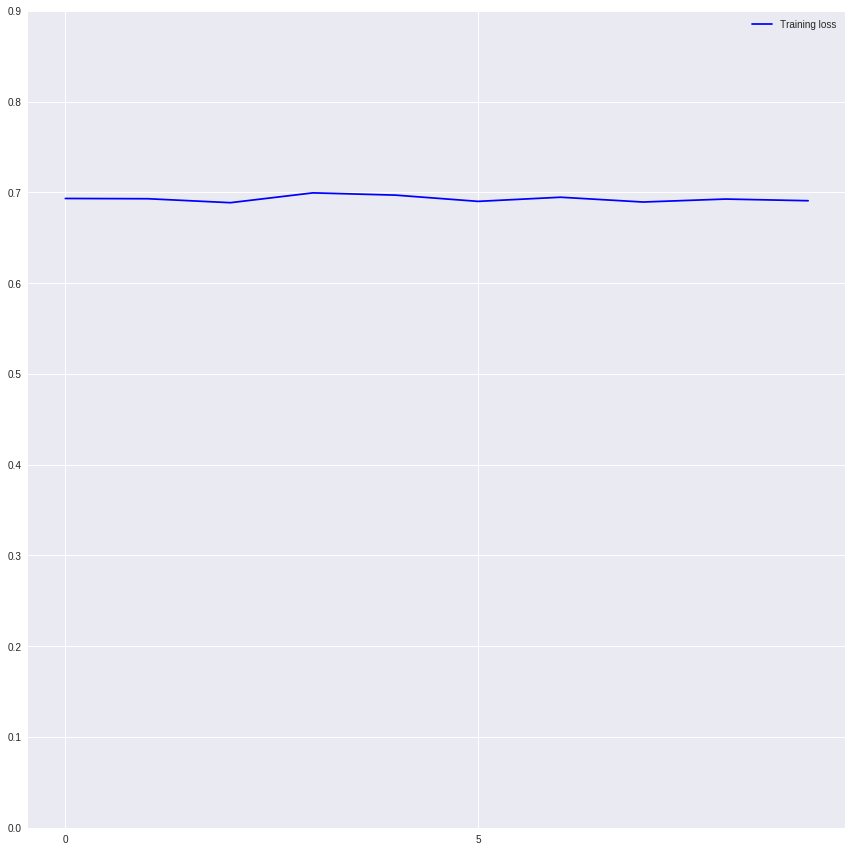

In [30]:
fig, ax1 = plt.subplots(1, 1, figsize=(12, 12))
ax1.plot(missloss, color='b', label="Training loss")
ax1.set_xticks(np.arange(0, iter, 5))
ax1.set_yticks(np.arange(0, 1, 0.1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [0]:
session = tf.Session()
session.run(tf.global_variables_initializer())
n,p = session.run([noise,prediction],feed_dict = {x:data[0], y:np.expand_dims(data[1],axis = 1)})
session.close()

In [45]:
p

array([[0.50079256],
       [0.50106394],
       [0.5007938 ],
       [0.50054044],
       [0.50045997],
       [0.5005854 ],
       [0.50073695],
       [0.5005766 ],
       [0.5007692 ],
       [0.50097746],
       [0.50078154],
       [0.50019294],
       [0.5006457 ],
       [0.5006373 ],
       [0.5004135 ],
       [0.5006579 ],
       [0.5006904 ],
       [0.50060266],
       [0.5004851 ],
       [0.50065917],
       [0.5003569 ],
       [0.50103074],
       [0.50083363],
       [0.5005863 ],
       [0.50064456],
       [0.500719  ],
       [0.50051767],
       [0.50063807],
       [0.5005023 ],
       [0.5006688 ],
       [0.5007876 ],
       [0.5006094 ],
       [0.5006138 ],
       [0.5008384 ],
       [0.5010984 ],
       [0.50070477],
       [0.5008794 ],
       [0.5007957 ],
       [0.5004733 ],
       [0.50064963],
       [0.5006153 ],
       [0.50080395],
       [0.500581  ],
       [0.50072193],
       [0.5003215 ],
       [0.5009139 ],
       [0.5007463 ],
       [0.500

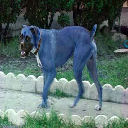

In [47]:
cv2_imshow((data[0][2] + n[2])*255)

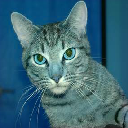

In [46]:
cv2_imshow((data[0][5] + n[5])*255)

In [0]:
tf.keras.backend.clear_session()
for i in range(10): gc.collect()